# Counterfactual Simulations

## Simulation configuration

To analyze the effectiveness of the tiebreakers, we are going to compare the performance of individual students in the school assignment process for each method to the base scenario where the policy has no equity tiebreaker. For this analysis, we are considering as _focal students those individuals who both are African-American, Latinx, or Pacific Islander (AALPI) and are eligible for free or reduced lunch (FRL)_.

The assignment policy used for these simulations restricts choice to medium zones (`policy='Medium'`) with guardrails for the three different diversity categories (`guard_rails=0`). The student data comes from the 2018-19 student assignment policy, and we use a choice model to generate the preference list of each student. This choice model is critical because the size of the true preference lists for the focal and non-focal students is systematically different. In particular, the focal students, in general, submitted smaller preferences lists. This difference amongst groups can artificially bias the simulation results.

## Generating individual focal students

The individual focal students for each block group are going to be generated at random. We are going to use the block groupes defined by SFUSD. The available data allows us to get rough estimates of the following probabilities for each block group:

- Probability a student is AALPI: $P(AALPI)$
- Probability a student is FRL: $P(FRL)$
- Probability a student is both AALPI and FRL: $P(AALPI \cap FRL)$
- Probability a student is FRL conditional on him being AALPI: $$P(FRL \mid AALPI) = \frac{P(AALPI \cap FRL)}{P(AALPI)}$$
- Probability a student is FRL conditional on him not being AALPI: $$P(FRL \mid \overline{AALPI}) = \frac{P(FRL)-P(AALPI \cap FRL)}{1-P(AALPI)}$$

Since some blocks have a small number of students we are going to use the mean of the posterior probability of a Bernoulli distribution with a uniform prior as probability estimates. Let $\theta$ be the parameter of the Bernoulli disttribution, $m$ the counts of interest and $n$ the total counts, we can get our probability estimates as: 

$$\hat{\theta} = \mathbb{E}\left[\theta\mid m,n\right]=\frac{m+1}{n+2}$$

For example, we can estimate the probability of a student being AALPI as

$$P(AALPI)=\frac{\textit{counts of AALPI}+1}{\textit{total counts}+2}$$

This procedure was done in a previous (preprocessing) stage.

## Models

We can tune each of the proposed tiebreakers to an arbitrary point in their respective ROC or Precision and Recall curves. Where we should stand in these curves ultimately depends on the decisions and criteria of the SFUSD.  In this case, we are restricting our analysis of tiebreaker performance to the false-positive rate (FPR) of the CTIP1 equity tiebreaker (`ctip1`) with the K - 5 data (`frl_key='kt5'`): 16%.

In particular, we are focusing on two alternative tiebreakers or methodologies: 
- the Naive Classifier at 16% FPR (`naive016`), hereafter referred to as the __Benchmark__ methodology,
- and a Propositional Classifier at 16% FPR (`pc3_030`), hereafter referred to as the __DSSG Equity Tiebreaker (DSSG ET)__.

The propositional classifier `pc3_030` considers redline and subsidized housing zones as eligibility criteria and the individual block requirement of more than 30% focal students. As a reminder, this analysis considers the students who are both AALPI and FRL as focal students:

```
eligibility_classifier = orClassifier(["Housing", "Redline"], binary_var=[0,1])
propositional_model = andClassifier(["pctBoth"], positive_group=positive_group, eligibility_classifier=eligibility_classifier, frl_key=frl_key)
```

In [1]:
import sys
from collections import OrderedDict
from IPython.core.display import display, HTML
sys.path.append('../')
from src.d06_reporting.simulation_evaluation import SimulationEvaluation

In [2]:
# SimulationEvaluation.get_available_models()

In [3]:
# Definition of focal student to be applied to the student data
def is_focal(row):
    return int(row['FRL'] & row['AALPI'])
# Simulation configuration
policy = 'Medium1'
guard_rails = 0
utility_model = True
num_iterations = 20
period = "1819"

# Methods to evaluate
method_name_dict = OrderedDict(none='No ET', ctip1='CTIP1', pc3_030='DSSG ET', naive016='Benchmark')

se = SimulationEvaluation(method_name_dict=method_name_dict, is_focal=is_focal, period=period)
se.set_simulation_config(equity_tiebreaker_list=list(method_name_dict.keys()),
                         num_iterations=num_iterations,
                         policy=policy,
                         guard_rails=guard_rails,
                         utility_model=utility_model)
# Load the rank data
se.query_rank_df()

,Designation Rate
method,
Benchmark,0.22
CTIP1,0.22
DSSG ET,0.22
No ET,0.22


status,Extended Positive,False Negative,False Positive,True Negative,True Positive,FPR,TPR
method,,,,,,,
Benchmark,5000.0,10660.0,3520.0,66260.0,10000.0,0.11,0.48
CTIP1,3880.0,13560.0,3300.0,67600.0,7100.0,0.10,0.34
DSSG ET,4800.0,11700.0,4100.0,65880.0,8960.0,0.12,0.43
No ET,0.0,20660.0,0.0,74780.0,0.0,0.00,0.00


As a sanity check we can quickly compute the designation rate of each simulated methodology. We can also check the False Positive Rate (FPR) and True Positive Rate (TPR) of each methodology for the student data. Let's remember that the 16% FPR referenced in the previous section is measured using the aggregated FRL and AALPI block data provided by SFUSD, which is different from the individual student data.

# General distribution of the tiebreaker and focal students

A first step in analyzing the effects of the different equity tiebreakers is to observe the proportion of students that belong to a focal block and the accuracy of the tiebreaker distribution. The latter refers to the distribution of False Negative (FN), True Negative (TN), True Positive (TP), False Positive (FP), and Extended Positive (EP). The latter term is used to reference the students who are focal if we extend the definition to those students who are either AALPI or FRL, and who get an equity tiebreaker.

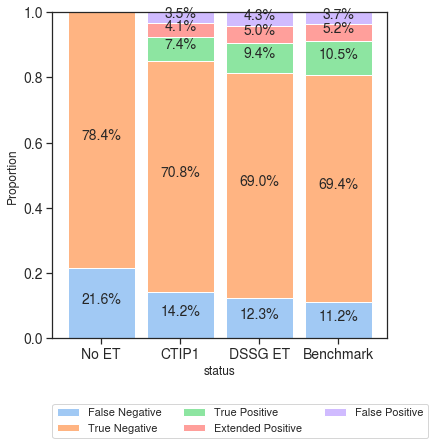

In [4]:
display(HTML("<h3>Figure 1: Student Distribution</h3>"))
se.rank_results_bar_plot()

We can see from the first plot that all three equity tiebreakers target a similar proportion of focal students (True Positive + False Negative) of approximately 21%. From the table, we can see that all models have a similar FPR but a different TPR. As expected from the sample evaluation, the Benchmark model has the highest TPR, followed by the DSSG ET and finally CTIP1. The methodology with no equity tiebreaker has 0.00 FPR and TPR.

# Quantifing the effects of the tiebreakers

To analyze the actual effects of each tiebreaker, we have generated two results. First, we look at the average change in rank of the assigned program for each type of student. We compute this change compared to the 'No ET' methodology. We then average the result over the 20 iterations. A positive change means the student is, on average, assigned to a worse-ranked program. The opposite is true for negative changes. 

The plot from Figure 2 shows the distribution of these changes. We also include a table with the mean and standard deviation of the results for each model. The plot from Figure 3 show the same results grouped by focal and not focal students.

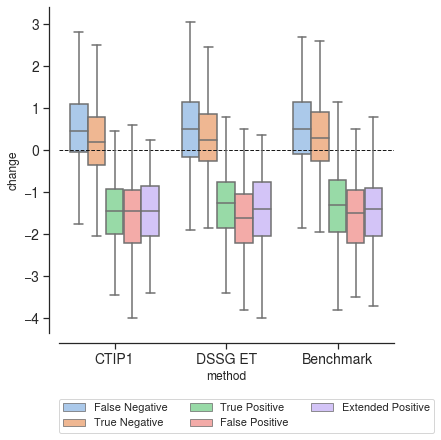

change                                  
                              mean   std   sem lower_95ci upper_95ci
method    status                                                    
Benchmark Extended Positive  -1.47  0.89  0.06      -1.58      -1.36
          False Negative      0.54  0.94  0.04       0.46       0.62
          False Positive     -1.59  0.88  0.07      -1.72      -1.46
          True Negative       0.34  0.88  0.02       0.31       0.37
          True Positive      -1.32  0.85  0.04      -1.40      -1.25
CTIP1     Extended Positive  -1.46  0.85  0.06      -1.58      -1.34
          False Negative      0.50  0.93  0.04       0.43       0.57
          False Positive     -1.56  0.87  0.07      -1.69      -1.43
          True Negative       0.24  0.88  0.02       0.21       0.27
          True Positive      -1.46  0.80  0.04      -1.55      -1.38
DSSG ET   Extended Positive  -1.44  0.92  0.06      -1.56      -1.33
          False Negative      0.53  0.97  0.04       0.45       0.60
          False Positive     -1.63  0.90  0.06      -1.76      -1.51
          True Negative       0.31  0.88  0.02       0.28       0.34
          True Positive      -1.29  0.84  0.04      -1.37      -1.21

In [5]:
display(HTML("<h3>Figure 2: Average change in rank of assigned program grouped by classification status</h3>"))
se.plot_improvement_over_none(hue='status')

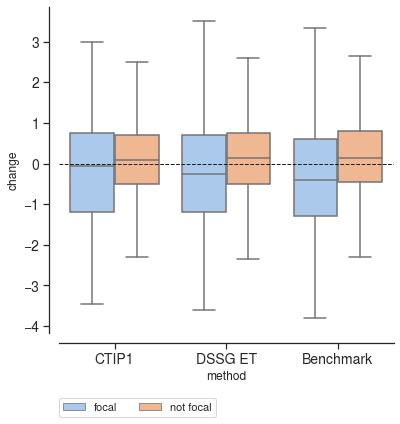

change                                  
                      mean   std   sem lower_95ci upper_95ci
method    focal                                             
Benchmark focal      -0.36  1.29  0.04      -0.44      -0.29
          not focal   0.12  1.06  0.02       0.09       0.16
CTIP1     focal      -0.18  1.29  0.04      -0.25      -0.10
          not focal   0.07  1.02  0.02       0.04       0.11
DSSG ET   focal      -0.26  1.28  0.04      -0.34      -0.18
          not focal   0.09  1.07  0.02       0.05       0.12

In [6]:
display(HTML("<h3>Figure 3: Average change in rank of assigned program grouped by student type</h3>"))
se.plot_improvement_over_none(hue='focal')

Figure 2 is clear evidence that the equity tiebreaker works. The majority of students who get an equity tiebreaker, under any methodology and irrespective if they are focal (True Positive), extended focal (Extended Positive), or not focal (False Positive), improve in the average rank of their assigned program. However, what is ultimately important is the performance of the focal students as a whole. 

From Figure 3, we can see that the effects of the tiebreaker over the overall focal and non-focal students are mixed. We can expect this outcome since the precision of the equity tiebreaker assignment is not perfect and, therefore, the gain of some focal students is the loss of others. However, if we look at the estimates of the mean effect on focal students' rank, we can measure a statistically significant negative change. In terms of the size of the effect, the Benchmark methodology has the largest impact, followed by the DSSG ET and then the CTIP1  

We can also observe that the Benchmark and DSSG ET have more than 50% of the focal students benefiting from the equity tiebreaker. We can see this in the negative medians obtained under both methodologies. We believe we can attribute these improvements over the CTIP1 to the better True Positive Rates of both these methodologies.

It might also be interesting to track the change in average rank of the focal students receiving the equity tiebreaker, i.e., the True Positives. We can do this by comparing these student's average rank of the assigned program with and without the equity tiebreaker. We can determine the latter by looking at the assignments under the 'No ET' methodology.

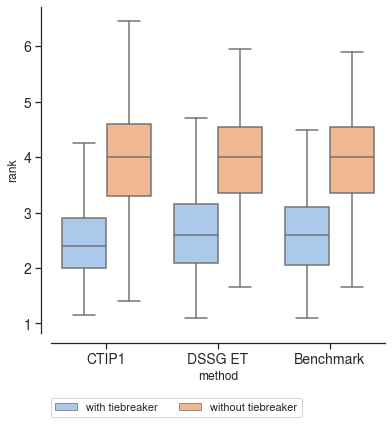

In [7]:
display(HTML("<h3>Figure 4: Distribution of average rank of assigned program for True Positives with and without tiebreakr</h3>"))
se.plot_improvement_tp()

From Figure 4, we can see that most focal students who get the tiebreaker get assigned to one of their top three ranked programs. Finally, in Figure 5, we plot the proportion of each type of student getting their top three choices. Here we can see that all three methodologies increase the proportion of focal students that get one of their top three choices, from 57% with no equity tiebreaker to 61% with the DSSG ET.

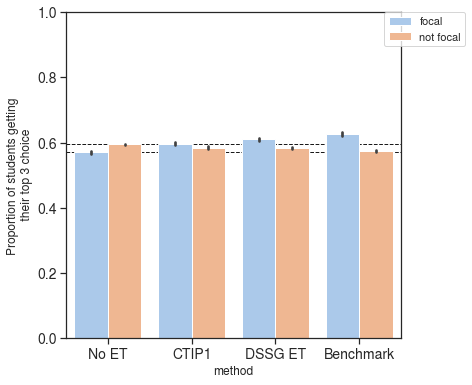

rank                                 
                     mean   std  sem lower_95ci upper_95ci
method    focal                                           
Benchmark focal      0.63  0.01  0.0       0.62       0.63
          not focal  0.57  0.01  0.0       0.57       0.58
CTIP1     focal      0.60  0.01  0.0       0.59       0.60
          not focal  0.58  0.01  0.0       0.58       0.59
DSSG ET   focal      0.61  0.01  0.0       0.60       0.62
          not focal  0.58  0.01  0.0       0.58       0.59
No ET     focal      0.57  0.01  0.0       0.57       0.57
          not focal  0.59  0.01  0.0       0.59       0.60

In [8]:
display(HTML("<h3>Figure 5: Proportion of students getting one of their top 3 choice</h3>"))
se.topkrank()

Although statistically significant, the effects of the equity tiebreaker are small. One explanation for that all the students receiving the tiebreaker belong to the same diversity category. Under the current assignment policy, each school has guard rails that restrict the number of seats available for each diversity category. The number of seats available depends on the overall diversity of the zone. This constraint means that students only have to compete against other students in the same diversity category. Since most students who are getting the tiebreaker belong to Diversity Category 2, the most underserved category, the equity tiebreaker prioritizes the TP over the FN. This result does not align with the School District's goal of prioritizing the focal students over the non-focal students.

For example, the following figure shows the composition of each Diversity Category in terms of the student classification status for the CTIP1 methodology. The last Diversity Category (labeled 2) is almost 40% focal students and almost 40% of the students receive the equity tiebreaker

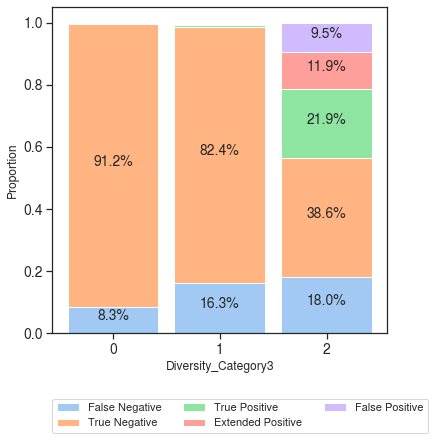

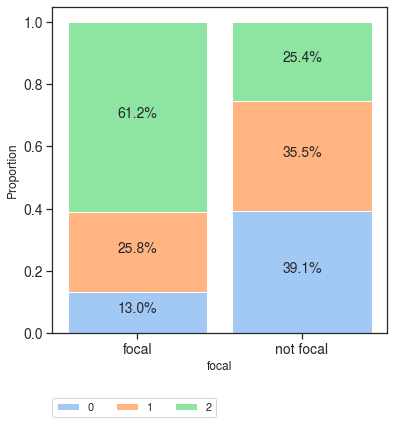

In [9]:
display(HTML("<h3>Figure 5: Composition of the Diversity Categories by classification status"))
se.rank_results_bar_plot_by_method(method='ctip1', x_axis='Diversity_Category3', hue='status')
se.rank_results_bar_plot_by_method(method='ctip1', x_axis='focal', hue='Diversity_Category3')

These results make us wonder if the FPR of the tiebreaker, or any selection/tunning metric, might affect performance more significantly. This hypothesis is an alternative to the belief that the method we use to select the focal blocks is a defining factor. If we have few FPs, we can expect to observe that most of the benefits from the equity tiebreaker go to the focal students.

Another alternative is reconsidering the definition of focal students to target a smaller fraction of the total population. Since the assignment policy includes guardrails for the different diversity categories, we can expect that one class will concentrate most of the focal students independent of the definition. This correlation between the equity tiebreaker and the diversity categories implies that the former can only make a significant difference if we target a smaller fraction of the students. The main difference between this solution, a narrow definition of focal students, rather than looking at a wider focal definition and setting a stricter threshold, is the arbitrariness of who gets left out.

# Remaining Questions

- Does targeting a smaller fraction of students improve the performance/effects of the equity tiebreaker.

- Another question is if the FPR of the tiebreaker, or any selection/tunning metric, affects performance more significantly.
